In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
import csv
import datetime as dt
from copy import deepcopy
from glob import glob
import ast
from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.debugger import set_trace
from difflib import SequenceMatcher

from scipy.stats import pearsonr, spearmanr

from nltk.corpus import words
word_list = words.words()

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(15,10), 'font.family': 'Times'})

tqdm.pandas()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)

RandomState(MT19937) at 0x108043C40

In [2]:
# dfs = []

# for file in glob('samples/sample_comments_*.tsv'):
#     sample = pd.read_csv(file, sep='\t',  quoting=csv.QUOTE_NONE, escapechar="\\", engine='python')
#     filename = file.split('.')[0] + '_output.txt'
#     with open(filename) as f:
#         output = [x.strip() for x in f.readlines()]
#     tagged_comment = [re.sub(r'(.*)\sREF_EXPRESSIONS:\s(.*)', r'\g<1>', x) for x in output]
#     ref_exps = [re.sub(r'(.*)\sREF_EXPRESSIONS:\s(.*)EXPLANATION:\s(.*)', r'\g<2>', x) for x in output]
# #     exps = [re.sub(r'(.*)\sREF_EXPRESSIONS:\s(.*)EXPLANATION:\s(.*)', r'\g<3>', x) for x in output]
#     sample['tagged_comment'] = tagged_comment
#     sample['ref_exp'] = ref_exps
# #     sample['explanation'] = exps
#     dfs.append(sample)

# df = pd.concat(dfs, ignore_index=True)
# del dfs

In [3]:
df = pd.read_csv('../../football/modeling/model-outputs/llama/no-wp/sample_comments.tsv', sep='\t',  quoting=csv.QUOTE_NONE, escapechar="\\", engine='python')
    
with open('../../football/modeling/model-outputs/llama/no-wp/seed3_sample-sents.txt') as f:
    tagged_sents = [x.strip() for x in f.readlines()]

with open('../../football/modeling/model-outputs/llama/no-wp/seed3_sample-output.txt') as f:
    ref_exps = [re.sub(r'(.*)\sREF_EXPRESSIONS:\s(.*)EXPLANATION:\s(.*)', r'\g<2>', x).strip() for x in f.read().split("======")]

df.shape, len(tagged_sents), len(ref_exps)

((100000, 6), 100000, 100001)

In [4]:
df.loc[:, 'tagged_comment'] = tagged_sents
df.loc[:, 'ref_exp'] = ref_exps[:-1]
df.tokenized_comment = df.tokenized_comment.apply(lambda x: x.strip())

## Make a list of referring expressions tagged by Llama

In [5]:
def make_list_of_refs(row):
    tags = [x.strip(' ,.?!\"\'srelv') for x in row['tagged_comment'].split() if x.strip(' ,.?!\"\'srelv') in ['[IN]', '[OUT]', '[OTHER]']]
    return tags
    
df['tags'] = df.progress_apply(lambda x: make_list_of_refs(x), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 195975.46it/s]


In [6]:
# counter = 0
def make_list_of_ents(row):
    tags = row.tags
    ents = []
    refs = row.ref_exp.split(',')
    for ref in refs:
        item = ref.strip("[\'\"] ")
        if len(item)>0:
            ents.append(item)
    if len(ents) != len(tags):
        ents = []
        a = row.tokenized_comment.split()
        b = row.tagged_comment.split()
        s = SequenceMatcher(None, a, b)
        for tag, i1, i2, j1, j2 in s.get_opcodes():
            if tag=='replace':
                ents.append(a[i1:i2])
        ents = sum(ents, [])
        if len(ents) >= len(tags):
            ents = ents[:len(tags)]
        else:
            # The remaining error is from the model inserting tags rather than replacing words with them
            tags = tags[:len(ents)]
            # set_trace()
            # global counter
            # counter += 1
    return ents
    
df['ents'] = df.progress_apply(lambda x: make_list_of_ents(x), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35168.51it/s]


In [7]:
a = "[SENT] Would n’t say [IN] ’re frauds if anything [IN] should be proud that [IN] ’re 3 - 1 despite the injuries on both sides of the ball . [SENT] If you expected a super bowl caliber team with this amount of injuries that ’s on you bud , should ’ve set your expectations lower .".split()
b = "[SENT] Would n’t say we ’re frauds if anything we should be proud that we ’re 3 - 1 despite the injuries on both sides of the ball . [SENT] If you expected a super bowl caliber team with this amount of injuries that ’s on you bud , should ’ve set your expectations lower .".split()

s = SequenceMatcher(None, a, b)
for tag, i1, i2, j1, j2 in s.get_opcodes():
    if tag=='replace':
        print('{:7}   a[{}:{}] --> b[{}:{}] {!r:>8} --> {!r}'.format(tag, i1, i2, j1, j2, a[i1:i2], b[j1:j2]))

replace   a[4:5] --> b[4:5] ['[IN]'] --> ['we']
replace   a[9:10] --> b[9:10] ['[IN]'] --> ['we']
replace   a[14:15] --> b[14:15] ['[IN]'] --> ['we']


## Do more tagging on top of the tagged comment 

In [8]:
postinfo = pd.read_csv('../data/postInfo.tsv', sep='\t')
gameinfo = pd.read_csv('../data/gameInfo.tsv', sep='\t')
teaminfo = pd.read_csv('../data/nfl_teams.csv')

teaminfo.shape, postinfo.shape, gameinfo.shape, df.shape

((32, 9), (2407, 4), (569, 8), (100000, 10))

In [9]:
teaminfo['team_name_short'] = teaminfo['team_name_short'].apply(lambda x: x.lower())

teams = teaminfo['team_name_short'].values.tolist()
subreddits = teaminfo['subreddit'].values.tolist()

teams_to_subreddit = {teams[i]: subreddits[i] for i in range(32)}
subreddit_to_teams = {subreddits[i]: teams[i] for i in range(32)}
team_names_dict = {x: [x] for x in teams}

for x in teams:
    team_id_word = teaminfo[teaminfo['team_name_short']==x]['team_id'].values[0]
    if team_id_word not in word_list:
        team_names_dict[x].append(team_id_word)
    
    team_id_pfr = teaminfo[teaminfo['team_name_short']==x]['team_id_pfr'].values[0]
    if team_id_pfr not in word_list:
        team_names_dict[x].append(team_id_pfr)
    
    # get approx location name? There will be overlaps
    city_name = teaminfo[teaminfo['team_name_short']==x]['team_name'].values[0].replace(x,'').strip()
    if city_name not in word_list:
        team_names_dict[x].append(city_name)
    team_names_dict[x] = list(set(team_names_dict[x]))

team_names_dict['jaguars'] += ['jag', 'cardiac jag', 'cardiac jaguar']
team_names_dict['patriots']+= ['pat', 'patsie', 'deflatriot', 'cheatriot', 'empire']
team_names_dict['colts'] += ['dolt']
team_names_dict['dolphins'] += ['fin', 'phin', 'fish']
team_names_dict['cardinals'] += ['card', 'cardiac card', 'cardiac cardinal']
team_names_dict['saints'] += ['aint', 'aint\'', 'sinner']
team_names_dict['lions'] += ['cardiac cat']
team_names_dict['falcons'] += ['dirty bird', 'bird']
team_names_dict['ravens'] += ['purple', 'purple murder']
team_names_dict['panthers'] += ['cardiac cat']
team_names_dict['bears'] += ['dabear', 'da bear']
team_names_dict['packers'] += ['cheesehead', 'the pack', 'gang green']
team_names_dict['texans'] += ['no-win']
team_names_dict['chiefs'] += ['chef']
team_names_dict['raiders'] += ['da raidah', 'fader', 'traitor', 'jokeland', 'silver and black']
team_names_dict['chargers'] += ['bolt']
team_names_dict['rams'] += ['goat', 'lamb']
team_names_dict['vikings'] += ['vike']
team_names_dict['giants'] += ['g-men', 'jint', 'big blue', 'wrecking crew', 'blue giant']
team_names_dict['jets'] += ['gang green', 'jest']
team_names_dict['eagles'] += ['iggle']
team_names_dict['steelers'] += ['stiller']
team_names_dict['49ers'] += ['whiner', 'forty-whiner', 'niner']
team_names_dict['seahawks'] += ['seagull']
team_names_dict['buccaneers'] += ['buc', 'buckie']
team_names_dict['titans'] += ['oiler', 'flaming thumbtack', 'titanic', 'traitor']
team_names_dict['commanders'] += ['deadskin', 'chesapeake watershed region indigenous person', 'potomac drainage basin indigenous person', 'skin']
team_names_dict['bills'] += ['b.i.l.l.s']
team_names_dict['bengals'] += ['bungles']
team_names_dict['browns'] += ['clown', 'dawg']
team_names_dict['cowboys'] += ['empire', 'americas team', 'america\'s team', 'cowgirl']
team_names_dict['broncos'] += ['donk']

team_names_dict['washington'] = team_names_dict['commanders']

## Remaining we/us referents

In [10]:
def replace_we(row):
    for match in re.finditer(r'\b((we)(\'re|\'ll|\'d)?|(us))\b', row.tagged_comment, flags=re.IGNORECASE):
        row.ents.append(match.group())
        row.tags.append('[IN]')
    row.tagged_comment = re.sub(r'\b((we)(\'re|\'ll|\'d)?|(us))\b', '[IN]', row.tagged_comment, flags=re.IGNORECASE)
    
    return row


df = df.progress_apply(lambda row: replace_we(row), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 26145.11it/s]


## Remaining names and nicknames

In [11]:
def replace_names(row):    
    in_regex = r'\b(' + '|'.join([re.escape(name) for name in team_names_dict[row.team]]) + r')(s)?\b'
    
    out_regex = r'\b(' + '|'.join([re.escape(name) for name in team_names_dict[row.opp]]) + r')(s)?\b'
    
    other_regex = r'\b(' 
    for t in teams:
        if t not in [row.team, row.opp]:
            other_regex += '|'.join([re.escape(name) for name in team_names_dict[t]]) + '|'
    other_regex = other_regex[:-1] + r')(s)?\b'    
        
    for match in re.finditer(in_regex, row.tagged_comment):
        row.ents.append(match.group())
        row.tags.append('[IN]')
    row.tagged_comment = re.sub(in_regex, '[IN]', row.tagged_comment)
    
    for match in re.finditer(out_regex, row.tagged_comment):
        row.ents.append(match.group())
        row.tags.append('[OUT]')
    row.tagged_comment = re.sub(out_regex, '[OUT]', row.tagged_comment)
    
    for match in re.finditer(other_regex, row.tagged_comment):
        row.ents.append(match.group())
        row.tags.append('[OTHER]')
    row.tagged_comment = re.sub(other_regex, '[OTHER]', row.tagged_comment)
    
    return row


df = df.progress_apply(lambda row: replace_names(row), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3214.59it/s]


In [12]:
df['we[in]'] = df['ents'].apply(lambda x: len(re.findall(r'\b((we)(\'re|\'ll|\'d)?|(us))\b', ' '.join(x), flags=re.IGNORECASE)))

df['[in]'] = df['tagged_comment'].apply(lambda x: x.count('[IN]'))
df['[out]'] = df['tagged_comment'].apply(lambda x: x.count('[OUT]'))
df['[other]'] = df['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
df['[sent]'] = df['ents'].apply(lambda x: sum([1 if 'SENT' in y else 0 for y in x]))

def count_names(row, teamname):
    regex = r'\b(' + '|'.join([re.escape(name) for name in team_names_dict[teamname]]) + r')(s)?\b'
    
    return len(re.findall(regex, ' '.join(row.ents), flags=re.IGNORECASE))

df['in_names'] = df.apply(lambda row: count_names(row, row.team), axis=1)
df['out_names'] = df.apply(lambda row: count_names(row, row.opp), axis=1)

df['[any]'] = df.ents.apply(lambda x: len(x))

df['none'] = df.apply(lambda x: 1 if ((x['[any]'])<1) else 0, axis=1)

In [13]:
np.round(df.none.sum()/df.shape[0], 2)

0.28

In [14]:
def find_they(ents, tags, group):
    length = min(len(ents), len(tags))
    count = 0
    for i in range(length):
        if tags[i]==group and len(re.findall(r'\b((they)(\'re|\'ll|\'d)?|them|(their\s(off|def)(.*)?))\b', ents[i], flags=re.IGNORECASE))>0:
            count += 1
    return count

df['they[in]'] = df.apply(lambda row: find_they(row.ents, row.tags, '[IN]'), axis=1)
df['they[out]'] = df.apply(lambda row: find_they(row.ents, row.tags, '[OUT]'), axis=1)
df['they_other'] = df.apply(lambda row: find_they(row.ents, row.tags, '[OTHER]'), axis=1)

In [15]:
all_df = {}

for variable in ['[in]', '[out]', '[other]', 'none', '[any]']:
    all_df[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>=min_prob))].shape[0]
            num_rel_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>min_prob))].shape[0]
            num_rel_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>min_prob))][variable].sum()
        all_df[variable].append(num_rel_comm/num_comm)

all_df['win-prob'] = [(x-2.5) for x in range(5, 101, 5)]
all_df = pd.melt(pd.DataFrame(all_df), id_vars='win-prob')

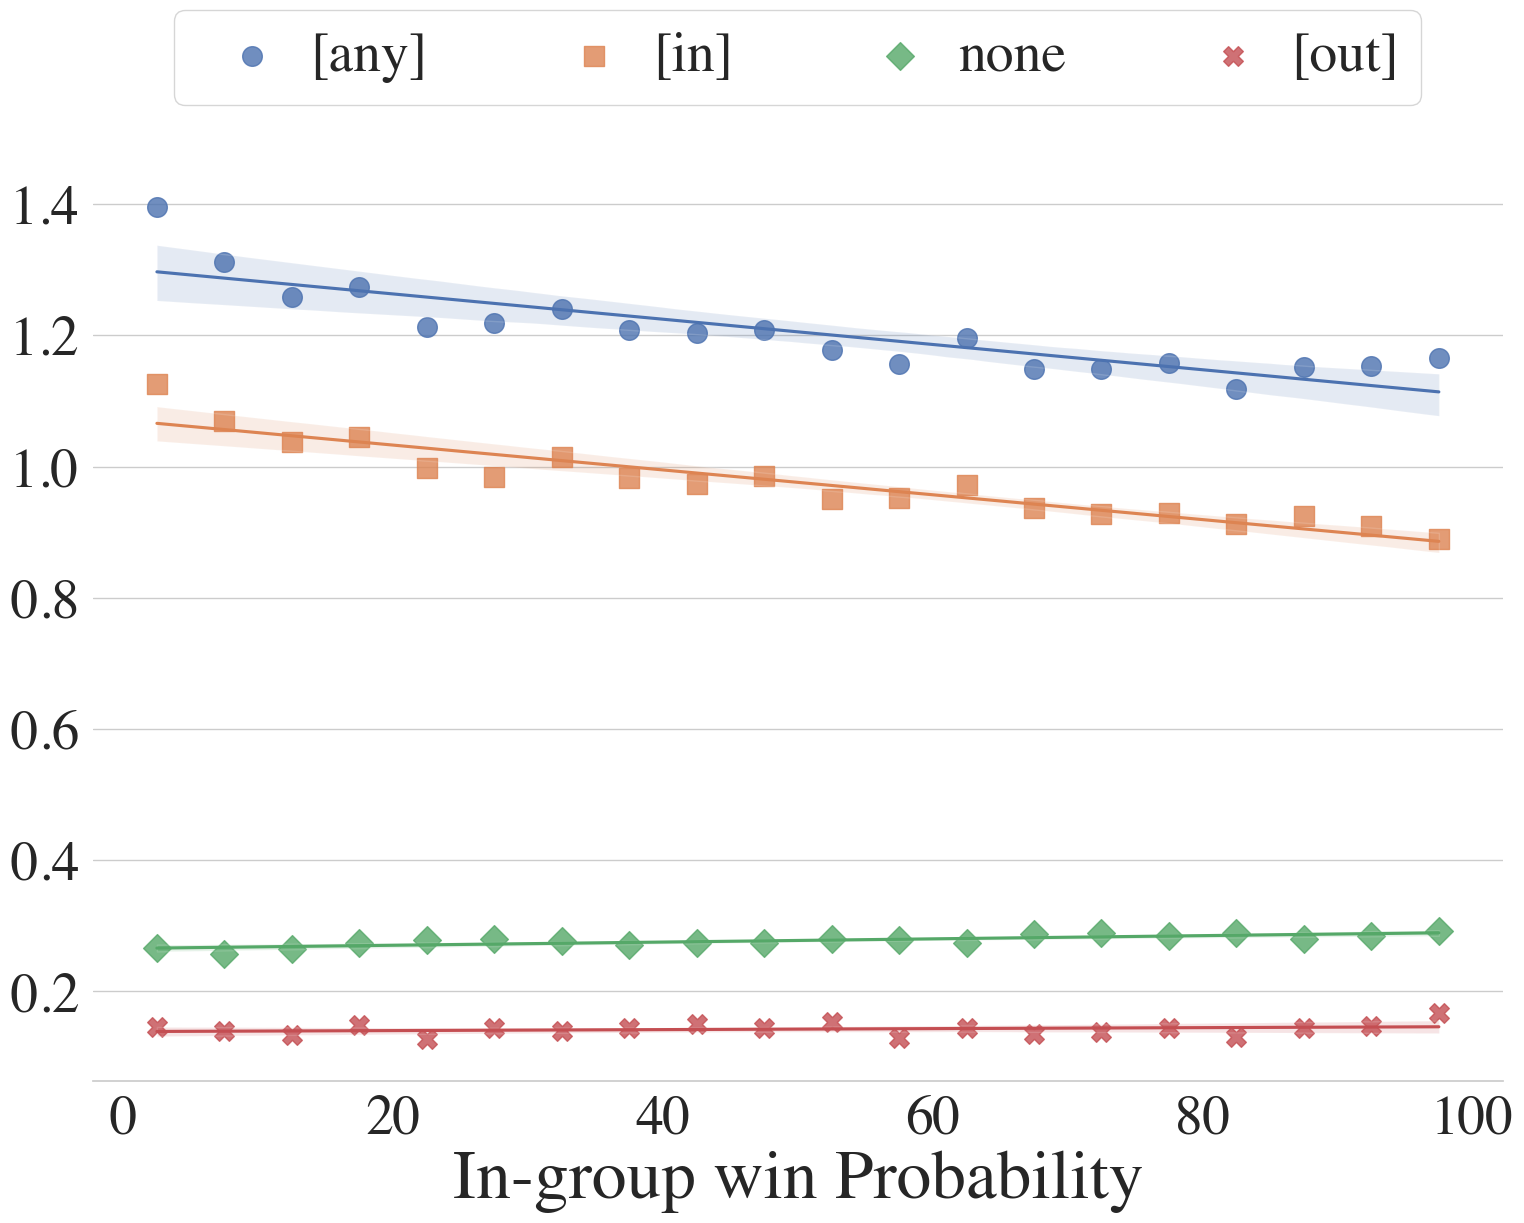

In [16]:
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_df[all_df.variable.isin(['[any]', '[in]', 'none', '[out]'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.5, hue_order=['[any]', '[in]', 'none', '[out]'], legend=False,markers=['o', 's', 'D', 'X'], scatter_kws={'s': 200}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=50)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('')
    g.fig.get_axes()[0].tick_params(axis='x', labelsize=40)
    g.fig.get_axes()[0].tick_params(axis='y', labelsize=40)
    g.fig.get_axes()[0].legend(loc='upper center', ncol=4, bbox_to_anchor=(.5, 1.2),fontsize=40, frameon=True, handletextpad=0.05)
    g.fig.get_axes()[0].spines["top"].set_visible(False)
    g.fig.get_axes()[0].spines["right"].set_visible(False)
    g.fig.get_axes()[0].spines["left"].set_visible(False)
    g.fig.get_axes()[0].grid(axis='x')
plt.show()
# plt.savefig('/Users/venkat/Downloads/trends-1.pdf', bbox_inches='tight', transparent=True)

In [49]:
g.axes[0,0].collections[2].get_offsets()

masked_array(
  data=[[2.5, 1.125465594981376],
        [7.5, 1.069813709531561],
        [12.5, 1.0380445898956843],
        [17.5, 1.0445300792121601],
        [22.5, 0.9983640081799591],
        [27.5, 0.9839666154184055],
        [32.5, 1.0142954390742],
        [37.5, 0.9822703767544939],
        [42.5, 0.9727567567567568],
        [47.5, 0.9861985472154964],
        [52.5, 0.9498777506112469],
        [57.5, 0.9513549533540648],
        [62.5, 0.9718865598027127],
        [67.5, 0.9375889890840057],
        [72.5, 0.9275296262534184],
        [77.5, 0.9289902280130293],
        [82.5, 0.9129086136960153],
        [87.5, 0.9241780362335048],
        [92.5, 0.9094054054054054],
        [97.5, 0.8894630420130307]],
  mask=[[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        

In [54]:
x_coords = g.axes[0,0].collections[0].get_offsets()[:, 0].data.tolist()
any_coords = g.axes[0,0].collections[0].get_offsets()[:, 1].data.tolist()
in_coords = g.axes[0,0].collections[2].get_offsets()[:, 1].data.tolist()
none_coords = g.axes[0,0].collections[4].get_offsets()[:, 1].data.tolist()
out_coords = g.axes[0,0].collections[6].get_offsets()[:, 1].data.tolist()

with open('/Users/venkat/Downloads/abs.tsv', 'w') as f:
    f.write("wp\tany\tin\tnone\tout\n")
    for i in range(len(x_coords)):
        f.write(str(x_coords[i]) + "\t" + str(np.round(any_coords[i],3)) + "\t" + str(np.round(in_coords[i],3)) + "\t" + str(np.round(none_coords[i],3)) + "\t" + str(np.round(out_coords[i],3))+"\n")
    

In [55]:
all_df = {}

for variable in ['we[in]', '[in]', '[out]', '[other]', '[sent]', 'in_names', 'out_names', 'they[in]', 'they[out]', 'they_other', 'none', '[any]']:
    all_df[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            if variable not in ['none', '[any]']:
                num_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>=min_prob))]['[any]'].sum()
            else:
                num_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>=min_prob))].shape[0]
            num_rel_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>=min_prob))][variable].sum()
        else:
            if variable not in ['none', '[any]']:
                num_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>min_prob))]['[any]'].sum()
            else:
                num_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>min_prob))].shape[0]
            num_rel_comm = df[((df['win_prob']<=max_prob) & (df['win_prob']>min_prob))][variable].sum()
        all_df[variable].append(num_rel_comm/num_comm)

all_df['win-prob'] = [(x-2.5) for x in range(5, 101, 5)]
all_df = pd.melt(pd.DataFrame(all_df), id_vars='win-prob')

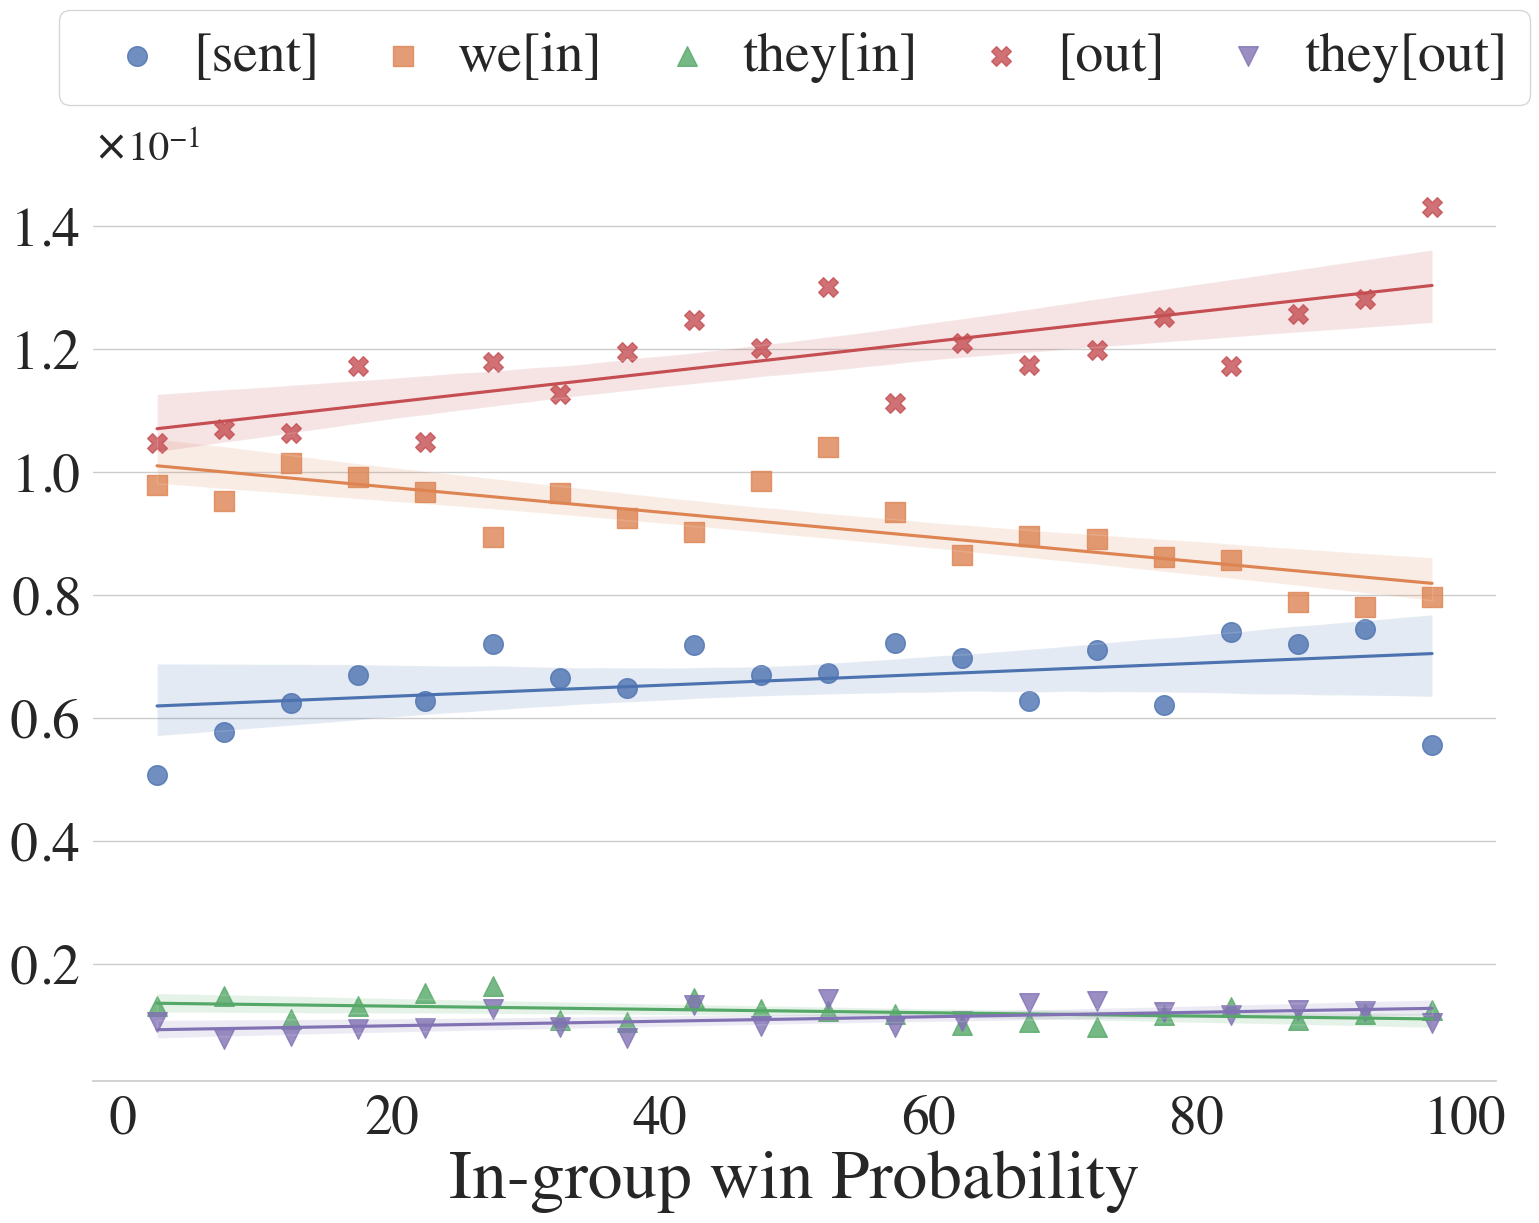

In [56]:
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_df[all_df.variable.isin(['[sent]', 'we[in]', 'they[in]', '[out]', 'they[out]'])], x='win-prob', y='value', hue='variable', hue_order=['[sent]', 'we[in]', 'they[in]', '[out]', 'they[out]'], markers=['o', 's', '^', 'X', 'v'], height=10, aspect=1.5, legend=False, scatter_kws={'s': 200}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=50)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('')
    g.fig.get_axes()[0].legend(loc='upper center', ncol=5, bbox_to_anchor=(.5, 1.2),fontsize=40, frameon=True, handletextpad=0.001, columnspacing=0.5)
    g.fig.get_axes()[0].tick_params(axis='x', labelsize=40)
    g.fig.get_axes()[0].tick_params(axis='y', labelsize=40)
    g.fig.get_axes()[0].spines["top"].set_visible(False)
    g.fig.get_axes()[0].spines["right"].set_visible(False)
    g.fig.get_axes()[0].spines["left"].set_visible(False)
    g.fig.get_axes()[0].grid(axis='x')
    g.fig.get_axes()[0].ticklabel_format(axis='y', style='scientific', scilimits=(-1, -1), useMathText=True)
    g.fig.get_axes()[0].yaxis.get_offset_text().set_fontsize(30)
plt.show()
# plt.savefig('/Users/venkat/Downloads/trends-2.pdf', bbox_inches='tight', transparent=True)

In [58]:
x_coords = g.axes[0,0].collections[0].get_offsets()[:, 0].data.tolist()
sent_coords = g.axes[0,0].collections[0].get_offsets()[:, 1].data.tolist()
wein_coords = g.axes[0,0].collections[2].get_offsets()[:, 1].data.tolist()
theyin_coords = g.axes[0,0].collections[4].get_offsets()[:, 1].data.tolist()
out_coords = g.axes[0,0].collections[6].get_offsets()[:, 1].data.tolist()
theyout_coords = g.axes[0,0].collections[8].get_offsets()[:, 1].data.tolist()

with open('/Users/venkat/Downloads/norm.tsv', 'w') as f:
    f.write("wp\tsent\twein\ttheyin\tout\ttheyout\n")
    for i in range(len(x_coords)):
        f.write(str(x_coords[i]) + "\t" + str(np.round(sent_coords[i],3)) + "\t" + str(np.round(wein_coords[i],3)) + "\t" + str(np.round(theyin_coords[i],3)) + "\t" + str(np.round(out_coords[i],3)) + "\t" + str(np.round(theyout_coords[i],3))+"\n")

## Estimate fit coefficients

In [20]:
X = np.linspace(5,100,20)
X = sm.add_constant(X)
for variable in ['[any]', 'none', 'we[in]', '[in]', '[out]', 'they[in]', 'they[out]']:
    y = all_df.loc[all_df.variable==variable, 'value'].values
    model = sm.OLS(y, X)
    results = model.fit()
    print(variable, " R2: ", np.round(results.rsquared_adj,2), "Slope: ", np.round(results.params[1], 5))

[any]  R2:  0.72 Slope:  -0.00193
none  R2:  0.65 Slope:  0.00024
we[in]  R2:  0.61 Slope:  -0.0002
[in]  R2:  0.31 Slope:  -0.00028
[out]  R2:  0.56 Slope:  0.00025
they[in]  R2:  0.15 Slope:  -3e-05
they[out]  R2:  0.25 Slope:  4e-05


In [25]:
df[((df['win_prob']<0.1) & (df['we[in]']>0))].sample(5)

,post_id,comment_id,tokenized_comment,opp,team,win_prob,tagged_comment,ref_exp,tags,ents,we[in],[in],[out],[other],[sent],in_names,out_names,[any],none,they[in],they[out],they_other
29958,yhhtvf,iuep30t,[SENT] Idk what makes you think anything will be different when we play the saints . [SENT] They 're currently dominating the raiders . [SENT] We are significantly worse than the raiders with or without Watt . [SENT] Embrace the suck this year .,eagles,steelers,0.001488,[SENT] Idk what makes you think anything will be different when [IN] play [OUT]. [SENT] [IN]'re currently dominating [OTHER]. [SENT] [IN] are significantly worse than [OTHER] with or without [IN]. [SENT] Embrace the suck this year.,"[SENT] Idk what makes you think anything will be different when we play the saints. [SENT] They're currently dominating the raiders. [SENT] We are significantly worse than the raiders with or without Watt. [SENT] Embrace the suck this year. \nIN-GROUP: Steelers\nOUT-GROUP: Eagles\nREF_EXPRESSIONS:\n['we', 'the saints', 'They', 'the raiders', 'We', 'the raiders', 'Watt', 'the raiders']\nEXPLANATION: The commenter is a Steelers fan, and the comment expresses frustration and resignation about the team's performance. The first sentence mentions ""we"" and ""the saints,"" indicating the in-group (Steelers) and an out-group (Saints) respectively. The second sentence refers to ""They"" and ""the raiders,"" where ""They"" likely refers to the Saints, who are currently dominating the Raiders. The third sentence compares ""We"" (Steelers) to ""the raiders"" and mentions ""Watt,"" who is a player for the Steelers, thus tagging ""We"" and ""Watt"" as [IN]. The fourth sentence is a general statement about the team's performance, not explicitly referring to any team, so it remains untagged. Therefore, the tags and referring expressions are correctly identified.\nTARGET: [SENT] Idk what makes you think anything will be different when [IN] play [OUT]. [SENT] [IN]'re currently dominating [OTHER]. [SENT] [IN] are significantly worse than [OTHER] with or without [IN]. [SENT] Embrace the suck this year.","[[IN], [OUT], [IN], [OTHER], [IN], [OTHER], [IN]]","[we, the, saints, ., They, 're, the]",1,4,1,2,0,0,0,7,0,1,0,0
99906,q0od59,hfa5o7g,[SENT] We 've forced them to punt twice and McVay keeps going for field goals .,cardinals,rams,0.038400,[SENT] [IN]'ve forced [OUT] to punt twice and [IN] keeps going for field goals.,"[SENT] We've forced them to punt twice and McVay keeps going for field goals. \nIN-GROUP: Rams\nOUT-GROUP: Cardinals\nREF_EXPRESSIONS:\n['We', 'them', 'McVay']\nEXPLANATION: The commenter is a Rams fan, and the comment is about the performance of the Rams' defense and their opponent's coach, McVay. 'We' refers to the in-group (Rams), as it is a common way for fans to refer to their own team. 'Them' refers to the out-group (Cardinals), as it is the opponent being forced to punt. 'McVay' refers to Sean McVay, the head coach of the Rams, and thus should be tagged as [IN] since he is part of the in-group team the commenter supports.\nTARGET: [SENT] [IN]'ve forced [OUT] to punt twice and [IN] keeps going for field goals.","[[IN], [OUT], [IN]]","[We, 've, them]",1,2,1,0,0,0,0,3,0,1,0,0
89799,rcvbnr,hnxo4c5,[SENT] We need a rebuild of the players and coaching staff,vikings,steelers,0.054826,[SENT] [IN] need a rebuild of the players and coaching staff,"[SENT] We need a rebuild of the players and coaching staff \nIN-GROUP: Steelers\nOUT-GROUP: Vikings\nREF_EXPRESSIONS:\n['We']\nEXPLANATION: The word 'We' in the comment typically refers to the in-group team that the commenter supports. In this case, the commenter is expressing a need for a rebuild of the players and coaching staff, which is something a fan would say about their own team. Therefore, 'We' should be tagged with [IN] since it refers to the in-group team, the Steelers.\nTARGET: [SENT] [IN] need a rebuild of the players and coaching staff",[[IN]],[We],1,1,0,0,0,0,0,1,0,0,0,0
5588,qoxpfx,

# Trends within teams, conferences, rivalries, special games, etc

In [ ]:
df.head()

In [ ]:
superbowls = ['2-12-2023-eagles', '2-13-2022-bengals']
playoffs = gameinfo[((gameinfo.schedule_date.str.startswith('1/')) | (gameinfo.schedule_date.str.startswith('2/')))]['game_id'].values.tolist()

playoffs = [x for x in playoffs if int(x.split('-')[1])>=10]

postseason_games = superbowls + playoffs

In [ ]:
df[df.post_id.isin(postinfo[postinfo.game_id.isin(superbowls)]['post_id'].values)][df.win_prob>0.75]

In [ ]:
df[df.post_id.isin(postinfo[postinfo.game_id.isin(playoffs)]['post_id'].values)].shape

## Playoffs

In [ ]:
pdf = df[df.post_id.isin(postinfo[postinfo.game_id.isin(playoffs)]['post_id'].values)]

pdf['we'] = pdf['ents'].apply(lambda x: len(re.findall(r'\b((we)(\'re|\'ll|\'d)?|us|(our\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

pdf['in'] = pdf['tagged_comment'].apply(lambda x: x.count('[IN]'))
pdf['out'] = pdf['tagged_comment'].apply(lambda x: x.count('[OUT]'))
pdf['other'] = pdf['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
pdf['sent'] = pdf['ents'].apply(lambda x: x.count('SENT'))

pdf['in_names'] = pdf.apply(lambda row: count_names(row, row.team), axis=1)
pdf['out_names'] = pdf.apply(lambda row: count_names(row, row.opp), axis=1)

pdf['any_ref'] = pdf.ents.apply(lambda x: len(x))
pdf['none'] = pdf.tags.apply(lambda x: 1 if len(x)==0 else 0)

pdf['they_in'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[IN]'), axis=1)
pdf['they_out'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OUT]'), axis=1)
pdf['they_other'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OTHER]'), axis=1)

all_pdf = {}

for variable in ['we', 'in', 'out', 'other', 'sent', 'any_ref', 'in_names', 'out_names', 'they_in', 'they_out', 'they_other', 'none']:
    all_pdf[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))][variable].sum()
        all_pdf[variable].append(num_rel_comm/num_comm)

all_pdf['win-prob'] = [x for x in range(5, 101, 5)]
all_pdf = pd.melt(pd.DataFrame(all_pdf), id_vars='win-prob')

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['we', 'out', 'other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in_names', 'out_names'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, robust=True)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in', 'any_ref'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['sent'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['they_in','they_out', 'they_other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['none'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

## Super bowl

In [ ]:
pdf = df[df.post_id.isin(postinfo[postinfo.game_id.isin(superbowls)]['post_id'].values)]

pdf['we'] = pdf['ents'].apply(lambda x: len(re.findall(r'\b((we)(\'re|\'ll|\'d)?|us|(our\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

pdf['in'] = pdf['tagged_comment'].apply(lambda x: x.count('[IN]'))
pdf['out'] = pdf['tagged_comment'].apply(lambda x: x.count('[OUT]'))
pdf['other'] = pdf['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
pdf['sent'] = pdf['ents'].apply(lambda x: x.count('SENT'))

pdf['in_names'] = pdf.apply(lambda row: count_names(row, row.team), axis=1)
pdf['out_names'] = pdf.apply(lambda row: count_names(row, row.opp), axis=1)

pdf['any_ref'] = pdf.ents.apply(lambda x: len(x))
pdf['none'] = pdf.tags.apply(lambda x: 1 if len(x)==0 else 0)

pdf['they_in'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[IN]'), axis=1)
pdf['they_out'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OUT]'), axis=1)
pdf['they_other'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OTHER]'), axis=1)

all_pdf = {}

for variable in ['we', 'in', 'out', 'other', 'sent', 'any_ref', 'in_names', 'out_names', 'they_in', 'they_out', 'they_other', 'none']:
    all_pdf[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))][variable].sum()
        all_pdf[variable].append(num_rel_comm/num_comm)

all_pdf['win-prob'] = [x for x in range(5, 101, 5)]
all_pdf = pd.melt(pd.DataFrame(all_pdf), id_vars='win-prob')

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['we', 'out', 'other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in_names', 'out_names'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, robust=True)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in', 'any_ref'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['sent'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['they_in','they_out', 'they_other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['none'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

# Rivalries

We're gonna look at the following rivalries from [CBS Sports](https://www.cbssports.com/nfl/news/nfls-top-10-divisional-rivalries-cowboys-eagles-packers-bears-battle-for-top-spot-on-all-time-list/)

-  Chargers vs Broncos
-  Falcons vs Saints
-  Bills vs Dolphins
-  49ers vs Rams
-  Jets vs Patriots
-  Commanders vs Giants
-  Chiefs vs Raiders
-  Ravens vs Steelers
-  Cowboys vs Eagles
-  Packers vs Bears

In [ ]:
rivalries = {
         'chargers': 'broncos',
         'falcons': 'saints',
         'bills': 'dolphins',
         '49ers': 'rams',
         'jets': 'patriots',
         'commanders': 'giants',
         'chiefs': 'raiders',
         'ravens': 'steelers',
         'cowboys': 'eagles',
         'packers': 'bears'
        }
rivalry_teams = list(rivalries.keys()) + list(rivalries.values())

def is_rivalry(team, opp):
    if ((team in rivalry_teams) and (opp in rivalry_teams)):
        if team in rivalries.keys():
            if opp == rivalries[team]:
                return 1
        elif opp in rivalries.keys():
            if team == rivalries[opp]:
                return 1
    return 0

df['rivalry'] = df.apply(lambda row: is_rivalry(row.team, row.opp), axis=1)


In [ ]:
pdf = df[df.rivalry==1]
pdf['we'] = pdf['ents'].apply(lambda x: len(re.findall(r'\b((we)(\'re|\'ll|\'d)?|us|(our\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

pdf['in'] = pdf['tagged_comment'].apply(lambda x: x.count('[IN]'))
pdf['out'] = pdf['tagged_comment'].apply(lambda x: x.count('[OUT]'))
pdf['other'] = pdf['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
pdf['sent'] = pdf['ents'].apply(lambda x: x.count('SENT'))

pdf['in_names'] = pdf.apply(lambda row: count_names(row, row.team), axis=1)
pdf['out_names'] = pdf.apply(lambda row: count_names(row, row.opp), axis=1)

pdf['any_ref'] = pdf.ents.apply(lambda x: len(x))
pdf['none'] = pdf.tags.apply(lambda x: 1 if len(x)==0 else 0)

pdf['they_in'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[IN]'), axis=1)
pdf['they_out'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OUT]'), axis=1)
pdf['they_other'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OTHER]'), axis=1)

all_pdf = {}

for variable in ['we', 'in', 'out', 'other', 'sent', 'any_ref', 'in_names', 'out_names', 'they_in', 'they_out', 'they_other', 'none']:
    all_pdf[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))][variable].sum()
        all_pdf[variable].append(num_rel_comm/num_comm)

all_pdf['win-prob'] = [x for x in range(5, 101, 5)]
all_pdf = pd.melt(pd.DataFrame(all_pdf), id_vars='win-prob')

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['we', 'out', 'other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in_names', 'out_names'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, robust=True)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in', 'any_ref'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['sent'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['they_in','they_out', 'they_other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['none'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

## Non-rivalries

In [ ]:
pdf = df[df.rivalry==0]
pdf['we'] = pdf['ents'].apply(lambda x: len(re.findall(r'\b((we)(\'re|\'ll|\'d)?|us|(our\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

pdf['in'] = pdf['tagged_comment'].apply(lambda x: x.count('[IN]'))
pdf['out'] = pdf['tagged_comment'].apply(lambda x: x.count('[OUT]'))
pdf['other'] = pdf['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
pdf['sent'] = pdf['ents'].apply(lambda x: x.count('SENT'))

pdf['in_names'] = pdf.apply(lambda row: count_names(row, row.team), axis=1)
pdf['out_names'] = pdf.apply(lambda row: count_names(row, row.opp), axis=1)

pdf['any_ref'] = pdf.ents.apply(lambda x: len(x))
pdf['none'] = pdf.tags.apply(lambda x: 1 if len(x)==0 else 0)

pdf['they_in'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[IN]'), axis=1)
pdf['they_out'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OUT]'), axis=1)
pdf['they_other'] = pdf.apply(lambda row: find_they(row.ents, row.tags, '[OTHER]'), axis=1)

all_pdf = {}

for variable in ['we', 'in', 'out', 'other', 'sent', 'any_ref', 'in_names', 'out_names', 'they_in', 'they_out', 'they_other', 'none']:
    all_pdf[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))].shape[0]
            num_rel_comm = pdf[((pdf['win_prob']<=max_prob) & (pdf['win_prob']>min_prob))][variable].sum()
        all_pdf[variable].append(num_rel_comm/num_comm)

all_pdf['win-prob'] = [x for x in range(5, 101, 5)]
all_pdf = pd.melt(pd.DataFrame(all_pdf), id_vars='win-prob')

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['we', 'out', 'other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in_names', 'out_names'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, robust=True)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['in', 'any_ref'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['sent'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()
    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['they_in','they_out', 'they_other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_pdf[all_pdf.variable.isin(['none'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

In [ ]:
df.to_csv('sample_sample.tsv', sep='\t', index=None, quoting=csv.QUOTE_NONE, escapechar="\\")

In [ ]:
with open('samples/sample_sample_comments.txt', 'w') as f:
    for line in df.tokenized_comment.values.tolist():
        f.write(line.replace('[SENT]', '').strip() + "\n")

# Length

In [ ]:
df['len'] = df['tokenized_comment'].apply(lambda x: len(x))

In [ ]:
df.loc[df['len']>128, 'len'] = 128

In [ ]:
sns.kdeplot(x=df[df.none==1].win_prob, y=df[df.none==1].len, fill=True)
plt.show()

As Win probability increases, comments get **less verbose**. There are fewer explicit in-group mentions. Out-group mentions are harder to verify one-way or another.

In [ ]:
spearmanr(df[df.none==1].win_prob.values, df[df.none==1].len.values)

In [ ]:
pearsonr(df[df.none==1].win_prob.values, df[df.none==1].len.values)

Spearman/Pearson's correlation of about **-0.07** between win_prob and comment length

# Specificity

In [ ]:
with open('samples/predictions.txt', 'r') as f:
    preds = [float(x.strip()) for x in f.readlines()]

df['spec'] = preds

In [ ]:
sns.kdeplot(x=df.win_prob, y=df.spec, fill=True)
plt.show()

In [ ]:
spearmanr(df.win_prob.values, df.spec.values)

In [ ]:
pearsonr(df.win_prob.values, df.spec.values)

## Why OTHER peak at 100?

In [ ]:
df[((df.other>0) & (df.win_prob>0.95))]

People are talking about the playoffs and Super Bowl

In [ ]:
df[((df.out>0) & (df.win_prob>0.95))]

## Number of comments across each win probability

In [ ]:
ax = sns.kdeplot(df, x='win_prob', common_norm=False, fill=True)
ax.set_xlabel('Win Probability')
ax.set_ylabel('Comment density')
plt.show()

## Do the same effects exist in the annotated data

In [ ]:
test = pd.read_csv('../data/wp/test_data.tsv', sep='\t', quoting=csv.QUOTE_NONE, escapechar="\\")
test.ref_expressions = test.ref_expressions.apply(lambda x: eval(x))

In [ ]:
test.head(2)

In [ ]:
test.shape

In [ ]:
test['len'] = test.tokenized_comment.apply(lambda x: len(x))
test.loc[test.len>128, 'len'] = 128
sns.kdeplot(x=test.win_prob, y=test.len, fill=True)
plt.show()

In [ ]:
test['we'] = test['ref_expressions'].apply(lambda x: len(re.findall(r'\b((we)(\'re|\'ll|\'d)?|us|(our\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

# test['they_in'] = test['ref_expressions'].apply(lambda x: len(re.findall(r'\b((they)(\'re|\'ll|\'d)?|them|(their\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

# test['they_out'] = test['ref_expressions'].apply(lambda x: len(re.findall(r'\b((they)(\'re|\'ll|\'d)?|them|(their\s(off|def)(.*)?))\b', ' '.join(x), flags=re.IGNORECASE)))

test['in'] = test['tagged_comment'].apply(lambda x: x.count('[IN]'))
test['out'] = test['tagged_comment'].apply(lambda x: x.count('[OUT]'))
test['other'] = test['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
test['sent'] = test['ref_expressions'].apply(lambda x: x.count('[SENT]'))

def count_names(row, teamname):
    regex = r'\b' + '|'.join([re.escape(name) for name in team_names_dict[teamname]]) + r'(s)?\b'
    
    return len(re.findall(regex, ' '.join(row.ref_expressions), flags=re.IGNORECASE))

test['in_names'] = test.apply(lambda row: count_names(row, row.team), axis=1)
test['out_names'] = test.apply(lambda row: count_names(row, row.opp), axis=1)

test['any_ref'] = test['in'] + test['out'] + test['other'] 

In [ ]:
all_test = {}

for variable in ['we', 'in', 'out', 'other', 'sent', 'any_ref', 'in_names', 'out_names']:
    all_test[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>=min_prob))].shape[0]
            num_rel_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>min_prob))].shape[0]
            num_rel_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>min_prob))][variable].sum()
        all_test[variable].append(num_rel_comm/num_comm)

all_test['win-prob'] = [x for x in range(5, 101, 5)]
all_test = pd.melt(pd.DataFrame(all_test), id_vars='win-prob')

In [ ]:
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_test[all_test.variable.isin(['we', 'they'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_test[all_test.variable.isin(['in', 'any_ref', 'out', 'other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

    
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_test[all_test.variable.isin(['in_names', 'out_names'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100})
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()

with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_test[all_test.variable.isin(['sent'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability',fontsize=30)
    g.fig.get_axes()[0].set_ylabel('')
#     g.fig.get_axes()[0].set_ylim(0.3,0.4)
    g.fig.get_axes()[0].set_title('Frequency of variable across win probabilities.',fontsize=30)
    g.fig.get_axes()[0].legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
    plt.show()